In [1]:
# install torch 
# !pip install "torch == 1.10.2"# load base package for the tasks from pytorchimport torch
# !pip install torch
import torch
from torch.utils.data import TensorDataset, DataLoader, RandomSampler, SequentialSampler

/Users/aapoh/codes/ghp/bert-multiclass/envs/lib/python3.10/site-packages/tqdm/auto.py:22: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm


In [2]:
# tell pytorch to run this model on GPU
# model.cuda()
import torch # check if we have cuda installed
if torch.cuda.is_available():    # to use GPU
    device = torch.device("cuda")
    print('There are %d GPU(s) available.' % torch.cuda.device_count())
    print('GPU is:', torch.cuda.get_device_name(0))
else:
    print('No GPU available, using the CPU instead.')
    device = torch.device("cpu")
    

No GPU available, using the CPU instead.


In [3]:
# from google.colab import drive
# drive.mount("/content/drive")

In [4]:
# load data
import pandas as pd
df = pd.read_csv("./traindata1.1.csv",engine="python")
df.drop(axis=1, inplace=True, columns=['UserID','Date/Time'] )
df.drop_duplicates(inplace=True)
# feature column and target
# ENGoogleTranslate | finalLabel5Classes
df[['ENGoogleTranslate','finalLabel5Classes']].head(5)
# df.columns

,ENGoogleTranslate,finalLabel5Classes
0,'g oh mammal feel sorry for the kids wod out w...,VNEG
1,'my message is a response to your demand that ...,NEU
2,'you are making fun of people who are single y...,NEG
3,'g is how to do',NEU
4,'g am honest and prectical quetical quems perm...,VPOS


In [9]:
# # text processing function 

import re
import string
def clean_text(text):
    # to lower case
    text = str(text)
    text = text.lower()
    # remove links
    text = re.sub('https:\/\/\S+', '', text) 
    # remove punctuation
    text = re.sub('[%s]' % re.escape(string.punctuation), '', text) 
    # remove next line     
    text = re.sub(r'[^ \w\.]', '', text) 
    # remove words containing numbers
    text = re.sub('\w*\d\w*', '', text)

    text = ' '.join( text.split() )
    
    return text# Create a new column called "Text" for collecting clean text
df['Text'] = df['ENGoogleTranslate'].apply(lambda x: clean_text(x))
df.head(5)

,topic,SearchTerm,emoticonBased,lexiconBased,Annotation 1,Annotation 2,Annotation 3,finalLabel5Classes,finalLabel3Classes,SN(Original Shona Tweet),ENGoogleTranslate,Text
0,Education,Vana,POS,NEG,VNEG,VNEG,NEU,VNEG,NEG,@GombaGuru @__vigie 😂😂 ah mudhara inzwaiwo tsi...,'g oh mammal feel sorry for the kids wod out w...,g oh mammal feel sorry for the kids wod out while
1,Agriculture,kudya,UNK,UNK,NEU,NEU,VPOS,NEU,NEU,@ChinyandeGeorge @ngadziore @nancynjenge @tapc...,'my message is a response to your demand that ...,my message is a response to your demand that w...
2,Sanitation,Vanhu,UNK,POS,NEG,NEU,NEG,NEG,NEG,Munenge muchiseka vanhu vari single imi muchii...,'you are making fun of people who are single y...,you are making fun of people who are single yo...
3,Finance,uyu,UNK,UNK,NEU,NEU,VNEG,NEU,NEU,@Sharonrose918 @habeeb_zw uyu oita sei,'g is how to do',g is how to do
4,Home_Affairs,Baba,POS,POS,NEU,VPOS,VPOS,VPOS,POS,@baba_nyenyedzi Am honest and practical questi...,'g am honest and prectical quetical quems perm...,g am honest and prectical quetical quems perm ...


In [10]:
# install transformers
!pip install transformers

In [11]:
# load xml roberta tokens
from transformers import AutoTokenizer
tokenizer = AutoTokenizer.from_pretrained('xlm-roberta-base')# Add words into token 
tokenizer.add_tokens(['covid', 'coronavirus'])

2

In [12]:
# example of tokenizing a sentence.
df.Text.values[0]
print({x : tokenizer.encode(x, add_special_tokens=False) for x in df.Text.values[0].split()})

# tokenizer(df.Text.values[0])['input_ids']

{'g': [706], 'oh': [13505], 'mammal': [21968, 141], 'feel': [12319], 'sorry': [59090], 'for': [100], 'the': [70], 'kids': [34376], 'wod': [6, 15263], 'out': [1810], 'while': [12960]}


max:  224
min:  3


(array([   0., 1000., 2000., 3000., 4000., 5000., 6000., 7000., 8000.,
        9000.]),
 [Text(0, 0.0, '0'),
  Text(0, 1000.0, '1000'),
  Text(0, 2000.0, '2000'),
  Text(0, 3000.0, '3000'),
  Text(0, 4000.0, '4000'),
  Text(0, 5000.0, '5000'),
  Text(0, 6000.0, '6000'),
  Text(0, 7000.0, '7000'),
  Text(0, 8000.0, '8000'),
  Text(0, 9000.0, '9000')])

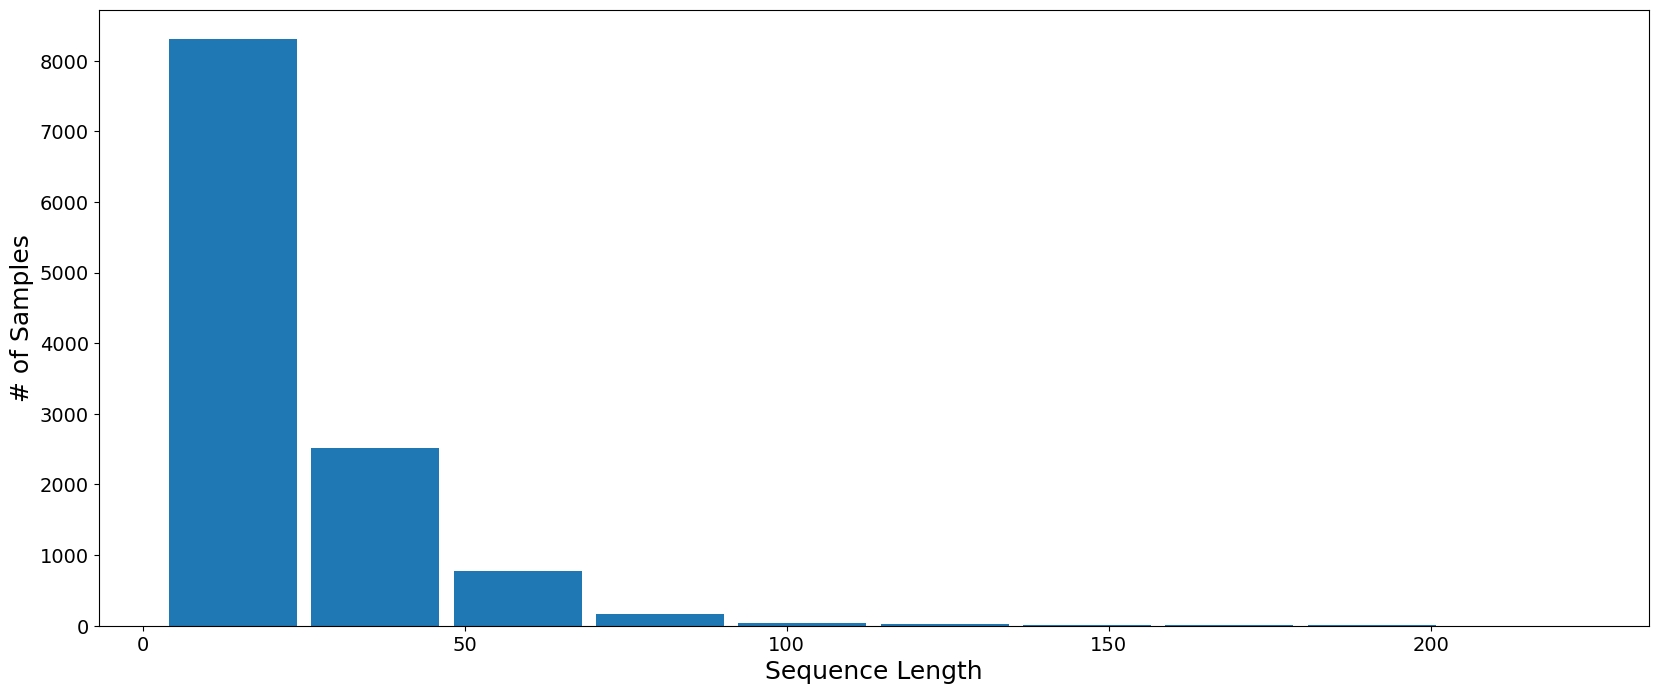

In [13]:
# tokenize all sentences and see length of the distribution length of the tokenized sentences.
# install matplotlib
# !pip install matplotlib # tokenize the text feature 
tokenized_feature_raw = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            df.Text.values.tolist(), 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True      
                   )# collect tokenized sentence length 
token_sentence_length = [len(x) for x in tokenized_feature_raw['input_ids']]
print('max: ', max(token_sentence_length))
print('min: ', min(token_sentence_length))# plot the distribution
import matplotlib.pyplot as plt
plt.figure(figsize=(20, 8))
plt.hist(token_sentence_length, rwidth = 0.9)
plt.xlabel('Sequence Length', fontsize = 18)
plt.ylabel('# of Samples', fontsize = 18)
plt.xticks(fontsize = 14)
plt.yticks(fontsize = 14)

In [14]:
# identify features and target
features = df.Text.values.tolist()
target = df['finalLabel5Classes'].values.tolist()

In [15]:
# tokenize features 
MAX_LEN = 256
tokenized_feature = tokenizer.batch_encode_plus(
                            # Sentences to encode
                            features, 
                            # Add '[CLS]' and '[SEP]'
                            add_special_tokens = True,
                            # Add empty tokens if len(text)<MAX_LEN
                            padding = 'max_length',
                            # Truncate all sentences to max length
                            truncation=True,
                            # Set the maximum length
                            max_length = MAX_LEN, 
                            # Return attention mask
                            return_attention_mask = True,
                            # Return pytorch tensors
                            return_tensors = 'pt'       
                   )
# tokenized_feature

In [16]:
# encode the target to numeric using sklearn
from sklearn.preprocessing import LabelEncoder
le = LabelEncoder()
le.fit(target)
target_num = le.transform(target)
target_num

array([3, 1, 0, ..., 0, 1, 0])

In [17]:
# Use 80% for training and 20% for validation
from sklearn.model_selection import train_test_split

train_inputs, validation_inputs, train_labels, validation_labels, train_masks, validation_masks = train_test_split(
    tokenized_feature['input_ids'], target_num, tokenized_feature['attention_mask'],
    random_state=2018, test_size=0.2, stratify=target)

In [18]:
# load training and validation data, into torch dataloader
# define batch_size
batch_size = 16 # Create the DataLoader for our training set
train_data = TensorDataset(train_inputs, train_masks, torch.tensor(train_labels))
train_sampler = RandomSampler(train_data)
train_dataloader = DataLoader(train_data, sampler=train_sampler, batch_size=batch_size)# Create the DataLoader for our test set
validation_data = TensorDataset(validation_inputs, validation_masks, torch.tensor(validation_labels))
validation_sampler = SequentialSampler(validation_data)
validation_dataloader = DataLoader(validation_data, sampler=validation_sampler, batch_size=batch_size)

In [19]:
# BertForSequenceClassification
from transformers import XLMRobertaForSequenceClassification, AdamW, get_linear_schedule_with_warmup, RobertaForSequenceClassification, BertForSequenceClassification

model = RobertaForSequenceClassification.from_pretrained(
    "roberta-base", 
    # Specify number of classes
    num_labels = len(set(target)), 
    # Whether the model returns attentions weights
    output_attentions = False,
    # Whether the model returns all hidden-states 
    output_hidden_states = False,
    # state problem type.
    problem_type="multi_label_classification",
)

Some weights of the model checkpoint at roberta-base were not used when initializing RobertaForSequenceClassification: ['lm_head.layer_norm.bias', 'roberta.pooler.dense.weight', 'lm_head.layer_norm.weight', 'roberta.pooler.dense.bias', 'lm_head.bias', 'lm_head.dense.bias', 'lm_head.dense.weight', 'lm_head.decoder.weight']
- This IS expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing RobertaForSequenceClassification from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).
Some weights of RobertaForSequenceClassification were not initialized from the model checkpoint at roberta-base and are newly initialized: ['classifier.dense.bias', 'classifier.

In [20]:
# Because we add two words [‘covid’, ‘coronavirus’] into the vocabulary, 
# we will need to resize the token to make sure the model pick it up as whole words.
model.resize_token_embeddings(len(tokenizer))

Embedding(250004, 768)

In [21]:
# add the optimizer
# Optimizer & Learning Rate Scheduler
optimizer = AdamW(model.parameters(), lr = 2e-5, eps = 1e-8 )

/Users/aapoh/codes/ghp/bert-multiclass/envs/lib/python3.10/site-packages/transformers/optimization.py:306: FutureWarning: This implementation of AdamW is deprecated and will be removed in a future version. Use the PyTorch implementation torch.optim.AdamW instead, or set `no_deprecation_warning=True` to disable this warning
  warnings.warn(


In [28]:
# Number of training epochs
epochs = 10 # Total number of training steps is number of batches * number of epochs.
total_steps = len(train_dataloader) * epochs# Create the learning rate scheduler
scheduler = get_linear_schedule_with_warmup(optimizer, num_warmup_steps = 0, num_training_steps = total_steps)

In [29]:
# training the model.
# Training
import time # Store the average loss after each epoch 
loss_values = []# number of total steps for each epoch
print('total steps per epoch: ',  len(train_dataloader) / batch_size)# looping over epochs
for epoch_i in range(0, epochs):
    
    print('\ntraining on epoch: ', epoch_i)    # set start time 
    t0 = time.time()
    # reset total loss
    total_loss = 0
    # model in training 
    model.train()
    # loop through batch 
    for step, batch in enumerate(train_dataloader):
        # Progress update every 50 step 
        if step % 50 == 0 and not step == 0:
            print('training on step: ', step)
            print('total time used is: {0:.2f} s'.format(time.time() - t0))
        # load data from dataloader
        b_input_ids = batch[0].to(device)
        b_input_mask = batch[1].to(device)
        b_labels = batch[2].to(device)
        # b_labels = torch.nn.functional.one_hot(batch[2].to(device), num_classes=5)
        # b_labels = b_labels.unsqueeze(1)
        # clear any previously calculated gradients 
        model.zero_grad()
        # get outputs
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask,
                        # labels=b_labels
                        )
        # get loss
        # loss = outputs[0]
        # total loss
        # total_loss += loss.item()
        # clip the norm of the gradients to 1.0.x
        torch.nn.utils.clip_grad_norm_(model.parameters(), 1.0)
        # update optimizer
        optimizer.step()
        # update learning rate 
        scheduler.step()    # Calculate the average loss over the training data.
    # avg_train_loss = total_loss / len(train_dataloader)    # Store the loss value for plotting the learning curve.
    # loss_values.append(avg_train_loss)
    # print("average training loss: {0:.2f}".format(avg_train_loss))

total steps per epoch:  37.125

training on epoch:  0
training on step:  50
total time used is: 178.60 s
training on step:  100
total time used is: 365.97 s
training on step:  150
total time used is: 553.77 s
training on step:  200
total time used is: 741.42 s
training on step:  250
total time used is: 928.45 s
training on step:  300
total time used is: 1116.03 s
training on step:  350
total time used is: 1304.82 s
training on step:  400
total time used is: 1495.53 s
training on step:  450
total time used is: 1793.31 s
training on step:  500
total time used is: 1976.52 s
training on step:  550
total time used is: 2165.96 s

training on epoch:  1
training on step:  50
total time used is: 181.52 s
training on step:  100
total time used is: 365.18 s
training on step:  150
total time used is: 551.19 s
training on step:  200
total time used is: 736.75 s
training on step:  250
total time used is: 931.57 s
training on step:  300
total time used is: 1118.26 s
training on step:  350
total time 

In [30]:
# Test
import numpy as np

t0 = time.time()# model in validation mode
model.eval()# save prediction
predictions,true_labels =[],[]# evaluate data for one epoch
for batch in validation_dataloader:
    # Add batch to GPU
    batch = tuple(t.to(device) for t in batch)    # Unpack the inputs from our dataloader
    b_input_ids, b_input_mask, b_labels = batch    # validation
    with torch.no_grad():
        outputs = model(b_input_ids,
                        token_type_ids=None,
                        attention_mask=b_input_mask)    # get output
                        
    logits = outputs[0]
    # move logits and labels to CPU
    logits = logits.detach().cpu().numpy()
    label_ids = b_labels.to('cpu').numpy()
    final_prediction = np.argmax(logits, axis=-1).flatten()
    predictions.append(final_prediction)
    true_labels.append(label_ids)
    
print('total time used is: {0:.2f} s'.format(time.time() - t0))

total time used is: 256.44 s


In [ ]:
# 
predictions

In [32]:
# convert numeric label to string
final_prediction_list = le.inverse_transform(np.concatenate(predictions))
final_truelabel_list = le.inverse_transform(np.concatenate(true_labels))

In [34]:
from sklearn.metrics import confusion_matrix, classification_report
cr = classification_report(final_truelabel_list, 
                           final_prediction_list, 
                           output_dict=False)
print(cr)

              precision    recall  f1-score   support

         NEG       0.00      0.00      0.00       665
         NEU       0.21      1.00      0.35       508
         POS       0.00      0.00      0.00       496
        VNEG       0.00      0.00      0.00       465
        VPOS       0.00      0.00      0.00       239

    accuracy                           0.21      2373
   macro avg       0.04      0.20      0.07      2373
weighted avg       0.05      0.21      0.08      2373



/Users/aapoh/codes/ghp/bert-multiclass/envs/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aapoh/codes/ghp/bert-multiclass/envs/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average, modifier, msg_start, len(result))
/Users/aapoh/codes/ghp/bert-multiclass/envs/lib/python3.10/site-packages/sklearn/metrics/_classification.py:1344: UndefinedMetricWarning: Precision and F-score are ill-defined and being set to 0.0 in labels with no predicted samples. Use `zero_division` parameter to control this behavior.
  _warn_prf(average,

Text(95.72222222222221, 0.5, 'Predicted Sentiment Label')

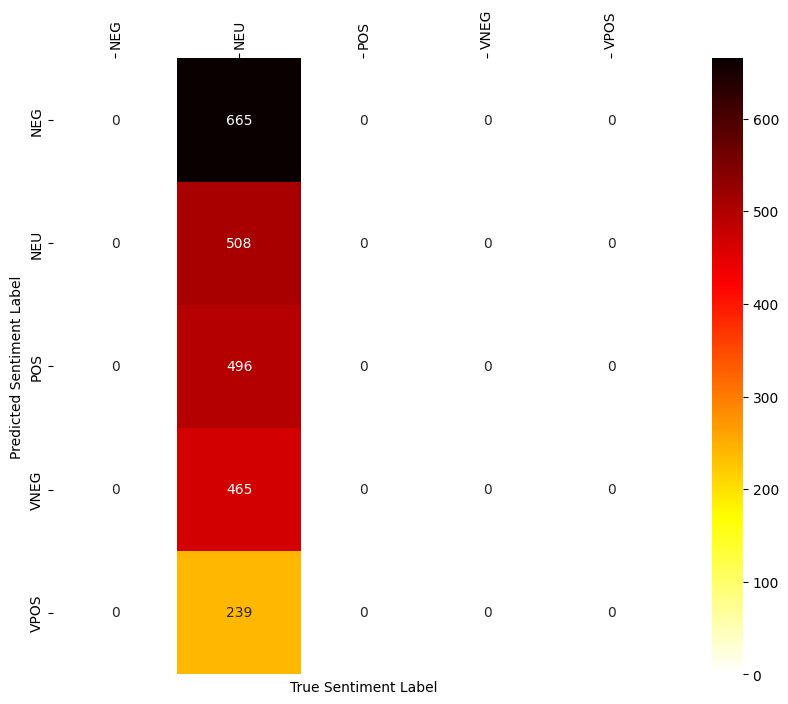

In [35]:
# install seaborn
# !pip install seaborn# 
# print cm heatmap
import seaborn as sns# return class label
class_label = np.unique(final_truelabel_list)# get confusion matrix 
cm = confusion_matrix(final_truelabel_list,
                      final_prediction_list)# covert it to dataframe for plotting
cm_df = pd.DataFrame(cm, 
                     index = class_label, 
                     columns = class_label)# plot it 
plt.figure(figsize = (10,8))
g = sns.heatmap(cm_df, cmap = 'hot_r', annot=True, fmt='g')
g.xaxis.set_ticks_position("top")
g.tick_params(axis='x', rotation=90)
g.set_xlabel("True Sentiment Label")
g.set_ylabel("Predicted Sentiment Label")